# What drives error?
>Investigating sources of error, per genome:

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [5]:
from src.simulation import simulate_from_ids
from src.torch_solver import TorchSolver, solve_table
from src.database import RnaDB

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

# Simulating and assessing:

## Single-genome solutions:

In [41]:
N_SAMPLES = 10
SCALE = 1e5

In [48]:
db = RnaDB()

results = pd.DataFrame(
    columns=[
        "genome",
        "trial",
        "a",
        "b",
        "a_hat",
        "b_hat",
        "final_loss",
        "a_err",
        "b_err",
        "n_reads",
    ]
)

for genome in tqdm(db.complete_genomes]):
    samples, ptrs, abundances, otus = simulate_from_ids(
        ids=[genome], n_samples=N_SAMPLES, scale=SCALE, verbose=False
    )
    solutions = solve_table(otus, [genome], db=db, verbose=False)
    for idx, (a_hat, b_hat, losses) in enumerate(solutions):
        a_err = np.abs(
            np.exp(a_hat[0]) - abundances[0, 0]
        )  # Not meaninful here
        b_err = np.abs(np.exp(b_hat[0]) - ptrs[0, 0])
        results = results.append(
            {
                "genome": genome,
                "trial": idx,
                "a": abundances[0, idx],
                "b": ptrs[0, idx],
                "a_hat": a_hat[0],
                "b_hat": b_hat[0],
                "final_loss": losses[-1],
                "a_err": a_err,
                "b_err": b_err,
                "n_reads": otus[idx].sum(),
            },
            ignore_index=True,
        )


100%|██████████| 100/100 [38:04<00:00, 22.84s/it]


In [49]:
results.to_csv("../data/scores/what_drives_error.csv")

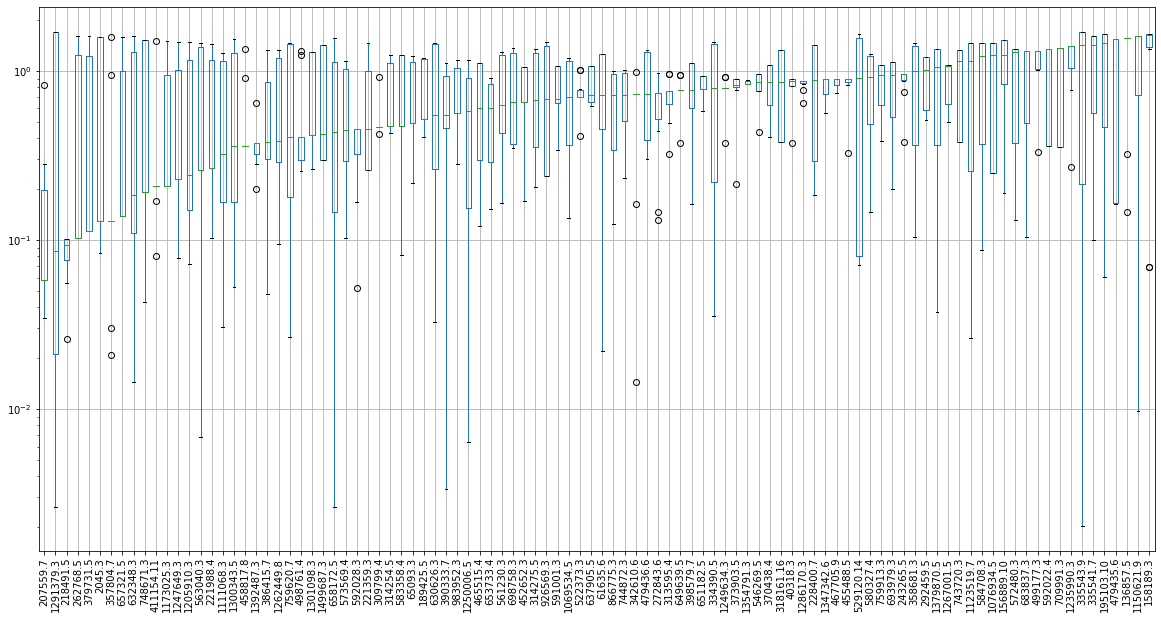

In [64]:
# Boxplot error values
# Borrows from https://stackoverflow.com/questions/21912634/how-can-i-sort-a-boxplot-in-pandas-by-the-median-values

df2 = pd.DataFrame(
    {col:vals["b_err"] for col, vals in results.groupby("genome")}
)
df2 = df2.reindex(df2.median().sort_values().index, axis=1)
df2.boxplot(figsize=(20, 10), rot=90)
plt.yscale("log")

Text(0.5, 1.0, 'PTR predictions can be all over the place')

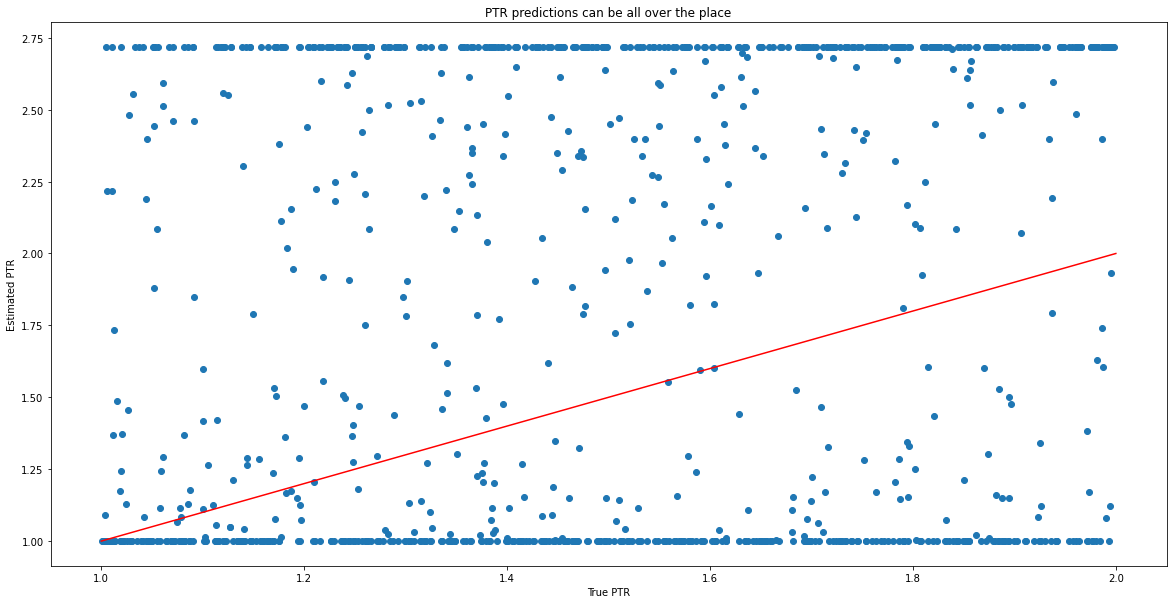

In [68]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["b"], np.exp(results["b_hat"]))
plt.plot([1,2], [1,2], color="red")
plt.xlabel("True PTR")
plt.ylabel("Estimated PTR")
plt.title("PTR predictions can be all over the place")

(1e-10, 1)

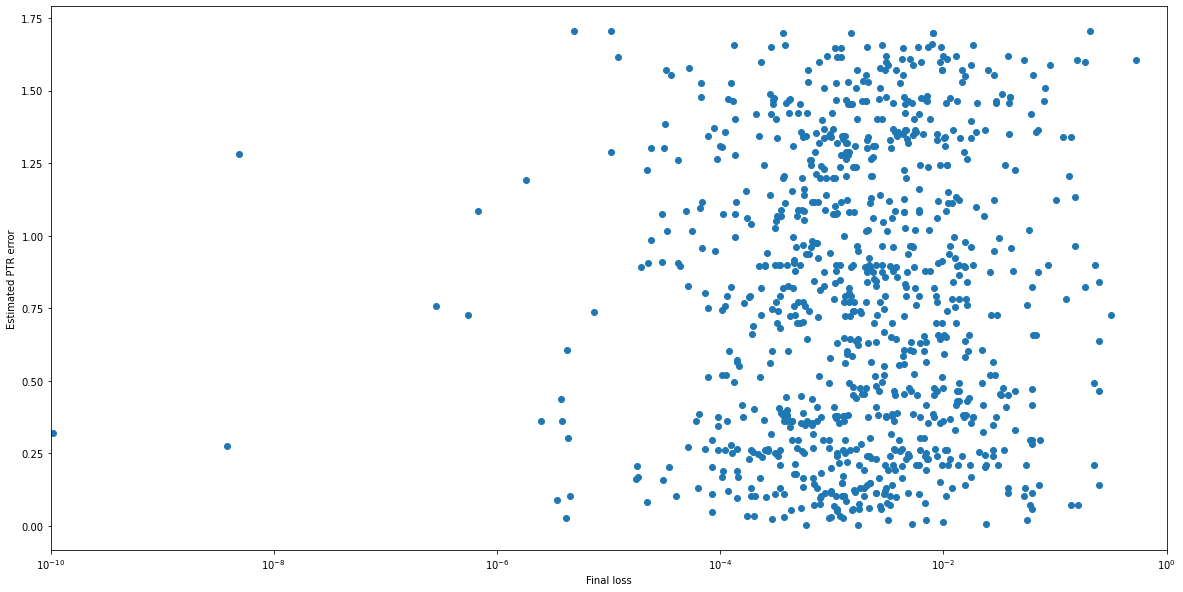

In [75]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["final_loss"], results["b_err"])
plt.xlabel("Final loss")
plt.ylabel("Estimated PTR error")
plt.xscale("log")
plt.xlim([1e-10, 1])
# plt.title("PTR predictions can be all over the place")

(0.1, 1000000.0)

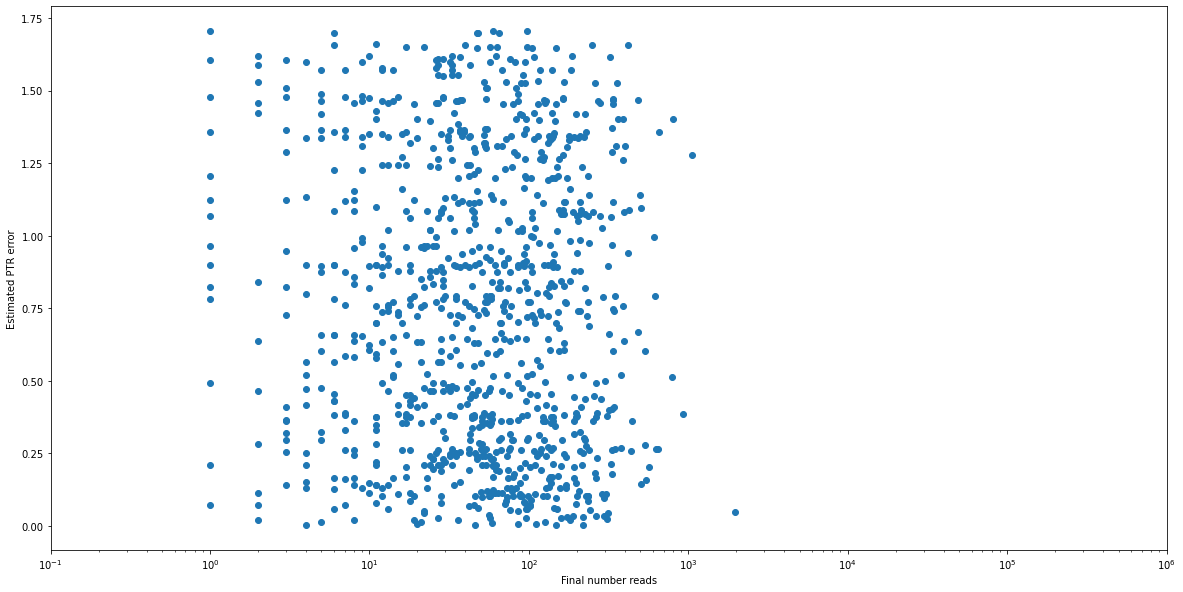

In [84]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["n_reads"], results["b_err"])
plt.xlabel("Final number reads")
plt.ylabel("Estimated PTR error")
plt.xscale("log")
plt.xlim([1e-1, 1e6])
# plt.title("PTR predictions can be all over the place")

Text(0, 0.5, 'Count')

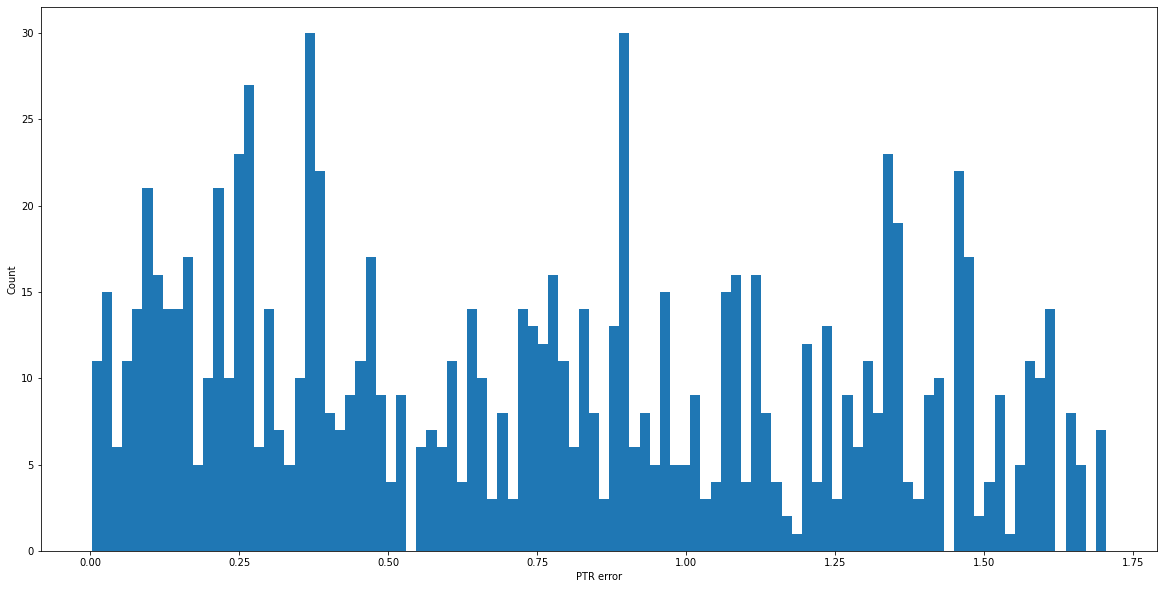

In [87]:
fig = plt.figure(figsize=(20, 10))
plt.hist(results["b_err"], bins=100)
plt.xlabel("PTR error")
plt.ylabel("Count")

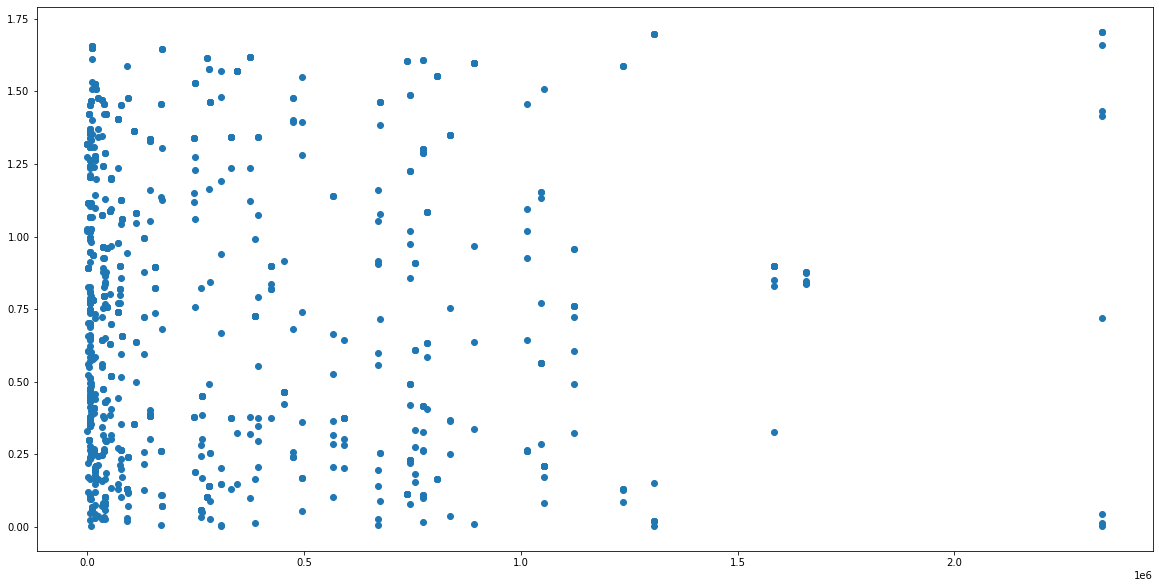

In [109]:
def min_16s_distance(genome):
    """Helper function to get the minimum distance between two 16S genes.    """
    positions = db[genome]["16s_position"]
    dists = np.zeros(shape=(len(positions), len(positions)))
    for i, pos1 in enumerate(positions):
        for j, pos2 in enumerate(positions):
            if i == j:
                dists[i,j] = np.inf # Don't count self
            else:
                d1 = np.abs(pos1 - pos2),
                d2 = np.abs(pos1 - pos2 + db[genome]["size"].max()), # wrap
                dists[i, j] = np.min([d1, d2])

    return dists.min()

fig = plt.figure(figsize=(20, 10))
plt.scatter(
    results["genome"].apply(min_16s_distance),
    results["b_err"],
)
plt.xlabel("Minimum 16S distance")
plt.ylabel("PTR error")
plt.xscale("log")